In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from typing import Optional
import torch
import torch.nn as nn
import tqdm
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import lovelyplots
plt.style.use('ipynb')

import e3nn
e3nn.set_optimization_defaults(jit_script_fx=False)
torch.set_float32_matmul_precision('high')

import e3tools
import rdkit
import rdkit.Chem as Chem

# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

from bond_predictor import models, rdkit_utils

In [4]:
# Check if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set default device.
torch.set_default_device(device)

cuda


In [5]:
# Read molecules from smiles.txt
smiles = open('smiles.txt').read().splitlines()

num_train_mols = 499000
train_mols = [Chem.MolFromSmiles(s) for s in smiles[:num_train_mols]]
train_mols = [Chem.AddHs(m) for m in train_mols if m is not None]

num_validation_mols = 1000
validation_mols = [Chem.MolFromSmiles(s) for s in smiles[num_train_mols:num_train_mols+num_validation_mols]]
validation_mols = [Chem.AddHs(m) for m in validation_mols if m is not None]


[18:21:42] Explicit valence for atom # 14 N, 4, is greater than permitted
[18:21:55] Explicit valence for atom # 13 N, 4, is greater than permitted


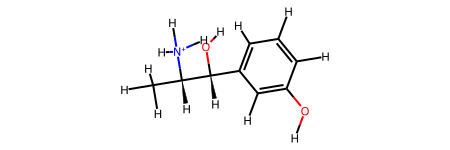

In [6]:
mol = train_mols[643]
mol

In [8]:
def visualize_bond_matrix(bond_matrix: torch.Tensor, atom_types: torch.Tensor):
    """
    Visualize bond matrix with atom labels
    
    Args:
        bond_matrix: NumPy array or tensor of bond types (num_atoms, num_atoms)
        atom_types: NumPy array or tensor of atom types (num_atoms,)
        atom_labels: Optional list of atom labels
    """
    
    # Convert to numpy if tensor
    if isinstance(bond_matrix, torch.Tensor):
        bond_matrix = bond_matrix.cpu().numpy()
    
    if atom_types is not None and isinstance(atom_types, torch.Tensor):
        atom_types = atom_types.cpu().numpy()
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Create atom labels if needed
    if atom_types is not None:
        atom_labels = [Chem.GetPeriodicTable().GetElementSymbol(int(atom_type)) for atom_type in atom_types]
    else:
        atom_labels = [str(i) for i in range(bond_matrix.shape[0])]
    
    # Create heatmap
    cmap = plt.get_cmap('Blues', 5)
    norm = mcolors.BoundaryNorm(np.arange(0, 5 + 1) - 0.5, 5)
    ax = sns.heatmap(
        bond_matrix, 
        annot=True, 
        cmap=cmap,
        norm=norm,
        fmt='d',
        xticklabels=atom_labels,
        yticklabels=atom_labels
    )
    
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5])
    cbar.set_ticklabels(['Nonbonded', 'Single', 'Double', 'Triple', 'Aromatic'])

    plt.title('Molecular Bond Matrix')
    plt.tight_layout()
    
    # Return the figure for display or saving
    return plt.gcf()

In [9]:
net = models.E3Conv()
net = torch.compile(net, dynamic=True, fullgraph=True)

print(sum(p.numel() for p in net.parameters() if p.requires_grad))

69153


In [10]:

def predict_logits(coordinates, atom_types, edge_index=None):
    if edge_index is None:
        edge_index = e3tools.radius_graph(coordinates, r=net.radial_cutoff)
    bond_logits, charge_logits = net(coordinates, atom_types, edge_index)
    return bond_logits, charge_logits

def logits_as_matrix(bond_logits, coordinates, edge_index=None):
    if edge_index is None:
        edge_index = e3tools.radius_graph(coordinates, r=net.radial_cutoff)

    assert bond_logits.shape[0] == edge_index.shape[1]
    assert bond_logits.ndim == 2

    # Map edge features to bond logits.
    N = coordinates.shape[0]
    bond_logits_matrix = torch.zeros((N, N, bond_logits.shape[-1]), dtype=bond_logits.dtype, device=bond_logits.device)
    
    # For the non-edges, set the bond type to "no bond".
    bond_logits_matrix[:, :, 0] = torch.max(bond_logits) + 1e6
    bond_logits_matrix[edge_index[0], edge_index[1]] = bond_logits
    bond_logits_matrix[edge_index[1], edge_index[0]] = bond_logits
    return bond_logits_matrix


def to_predictions(bond_logits):
    return torch.argmax(bond_logits, dim=-1)

def predict_bond_matrix(coordinates, atom_types, edge_index=None):
    bond_logits, _ = predict_logits(coordinates, atom_types, edge_index)
    bond_logits_matrix = logits_as_matrix(bond_logits, coordinates, edge_index)
    return to_predictions(bond_logits_matrix)


def embed_charges(charges, max_charge: Optional[int] = None):
    if max_charge is None:
        max_charge = net.max_charge
    return (charges + max_charge).long()


In [11]:
mol = Chem.MolFromSmiles('[Al+3].[Al+3].[O-2].[O-2].[O-2]')
charges = np.array([atom.GetFormalCharge() for atom in mol.GetAtoms()])


Molecule has 25 atoms
Coordinates shape: torch.Size([25, 3])
Atom types: tensor([6, 6, 6, 8, 6, 6, 8, 6, 8, 8, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0')
Bond matrix shape: torch.Size([25, 25])
Charges: tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       device='cuda:0')


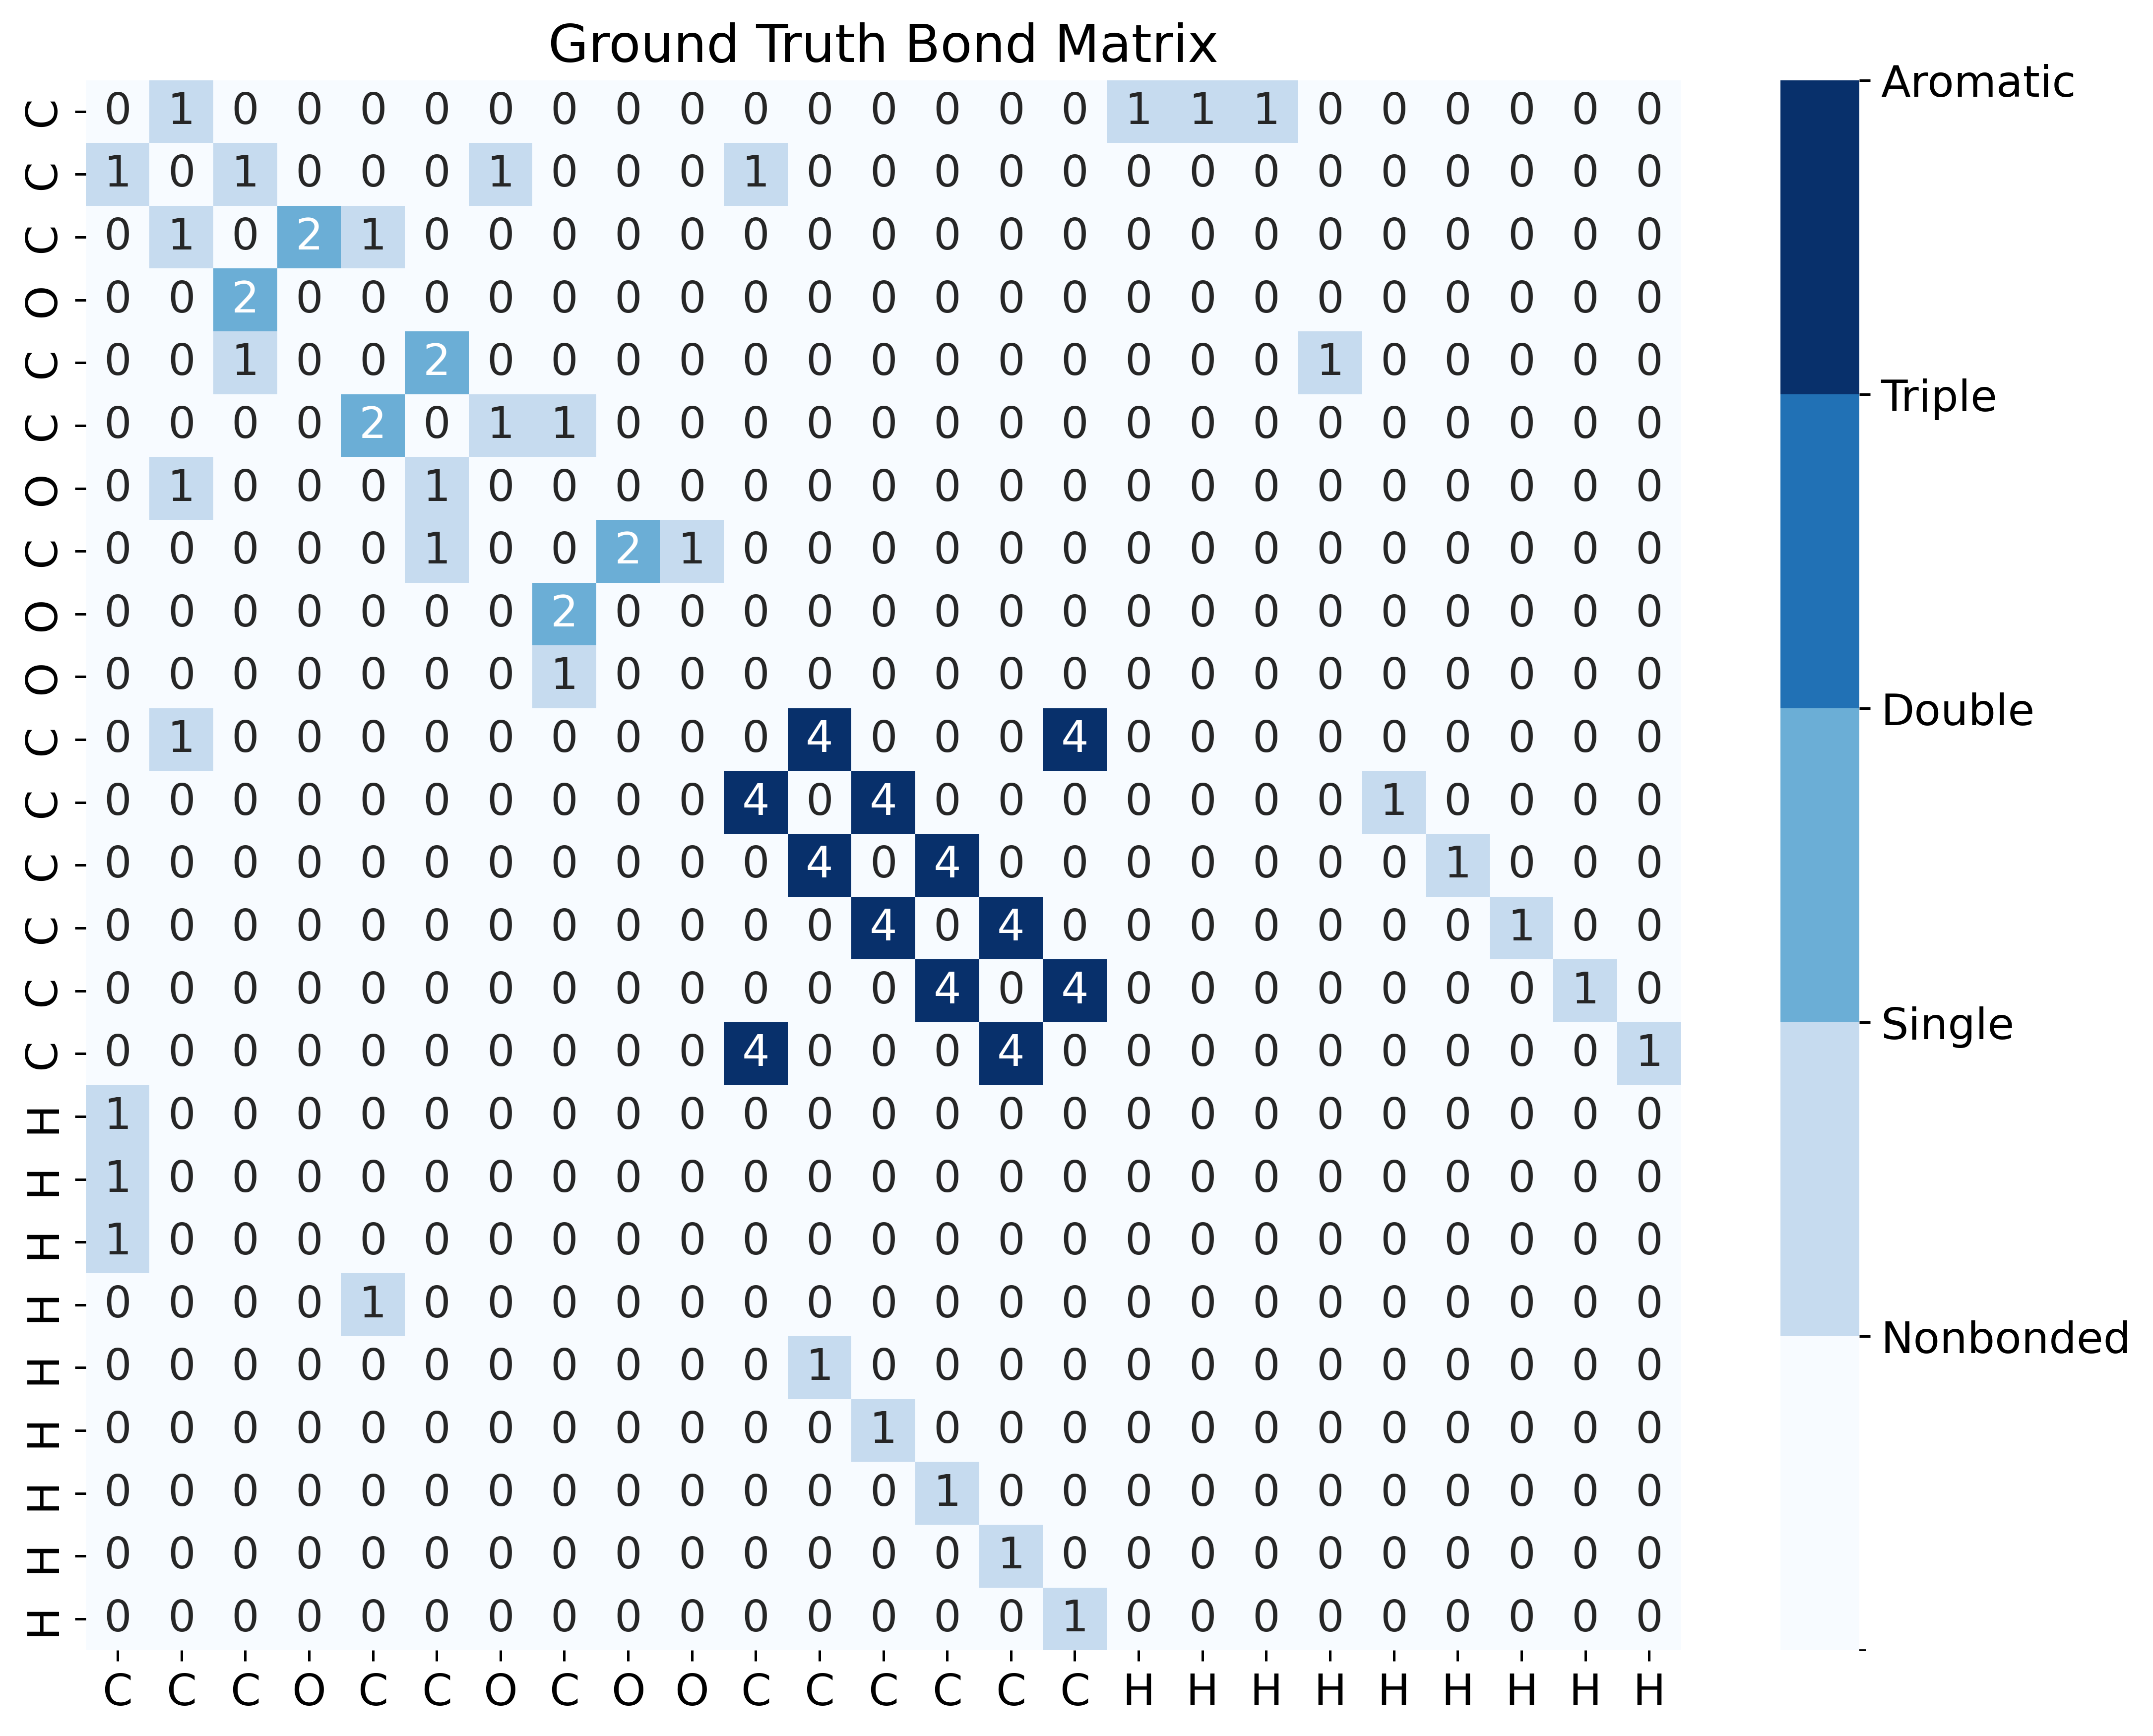

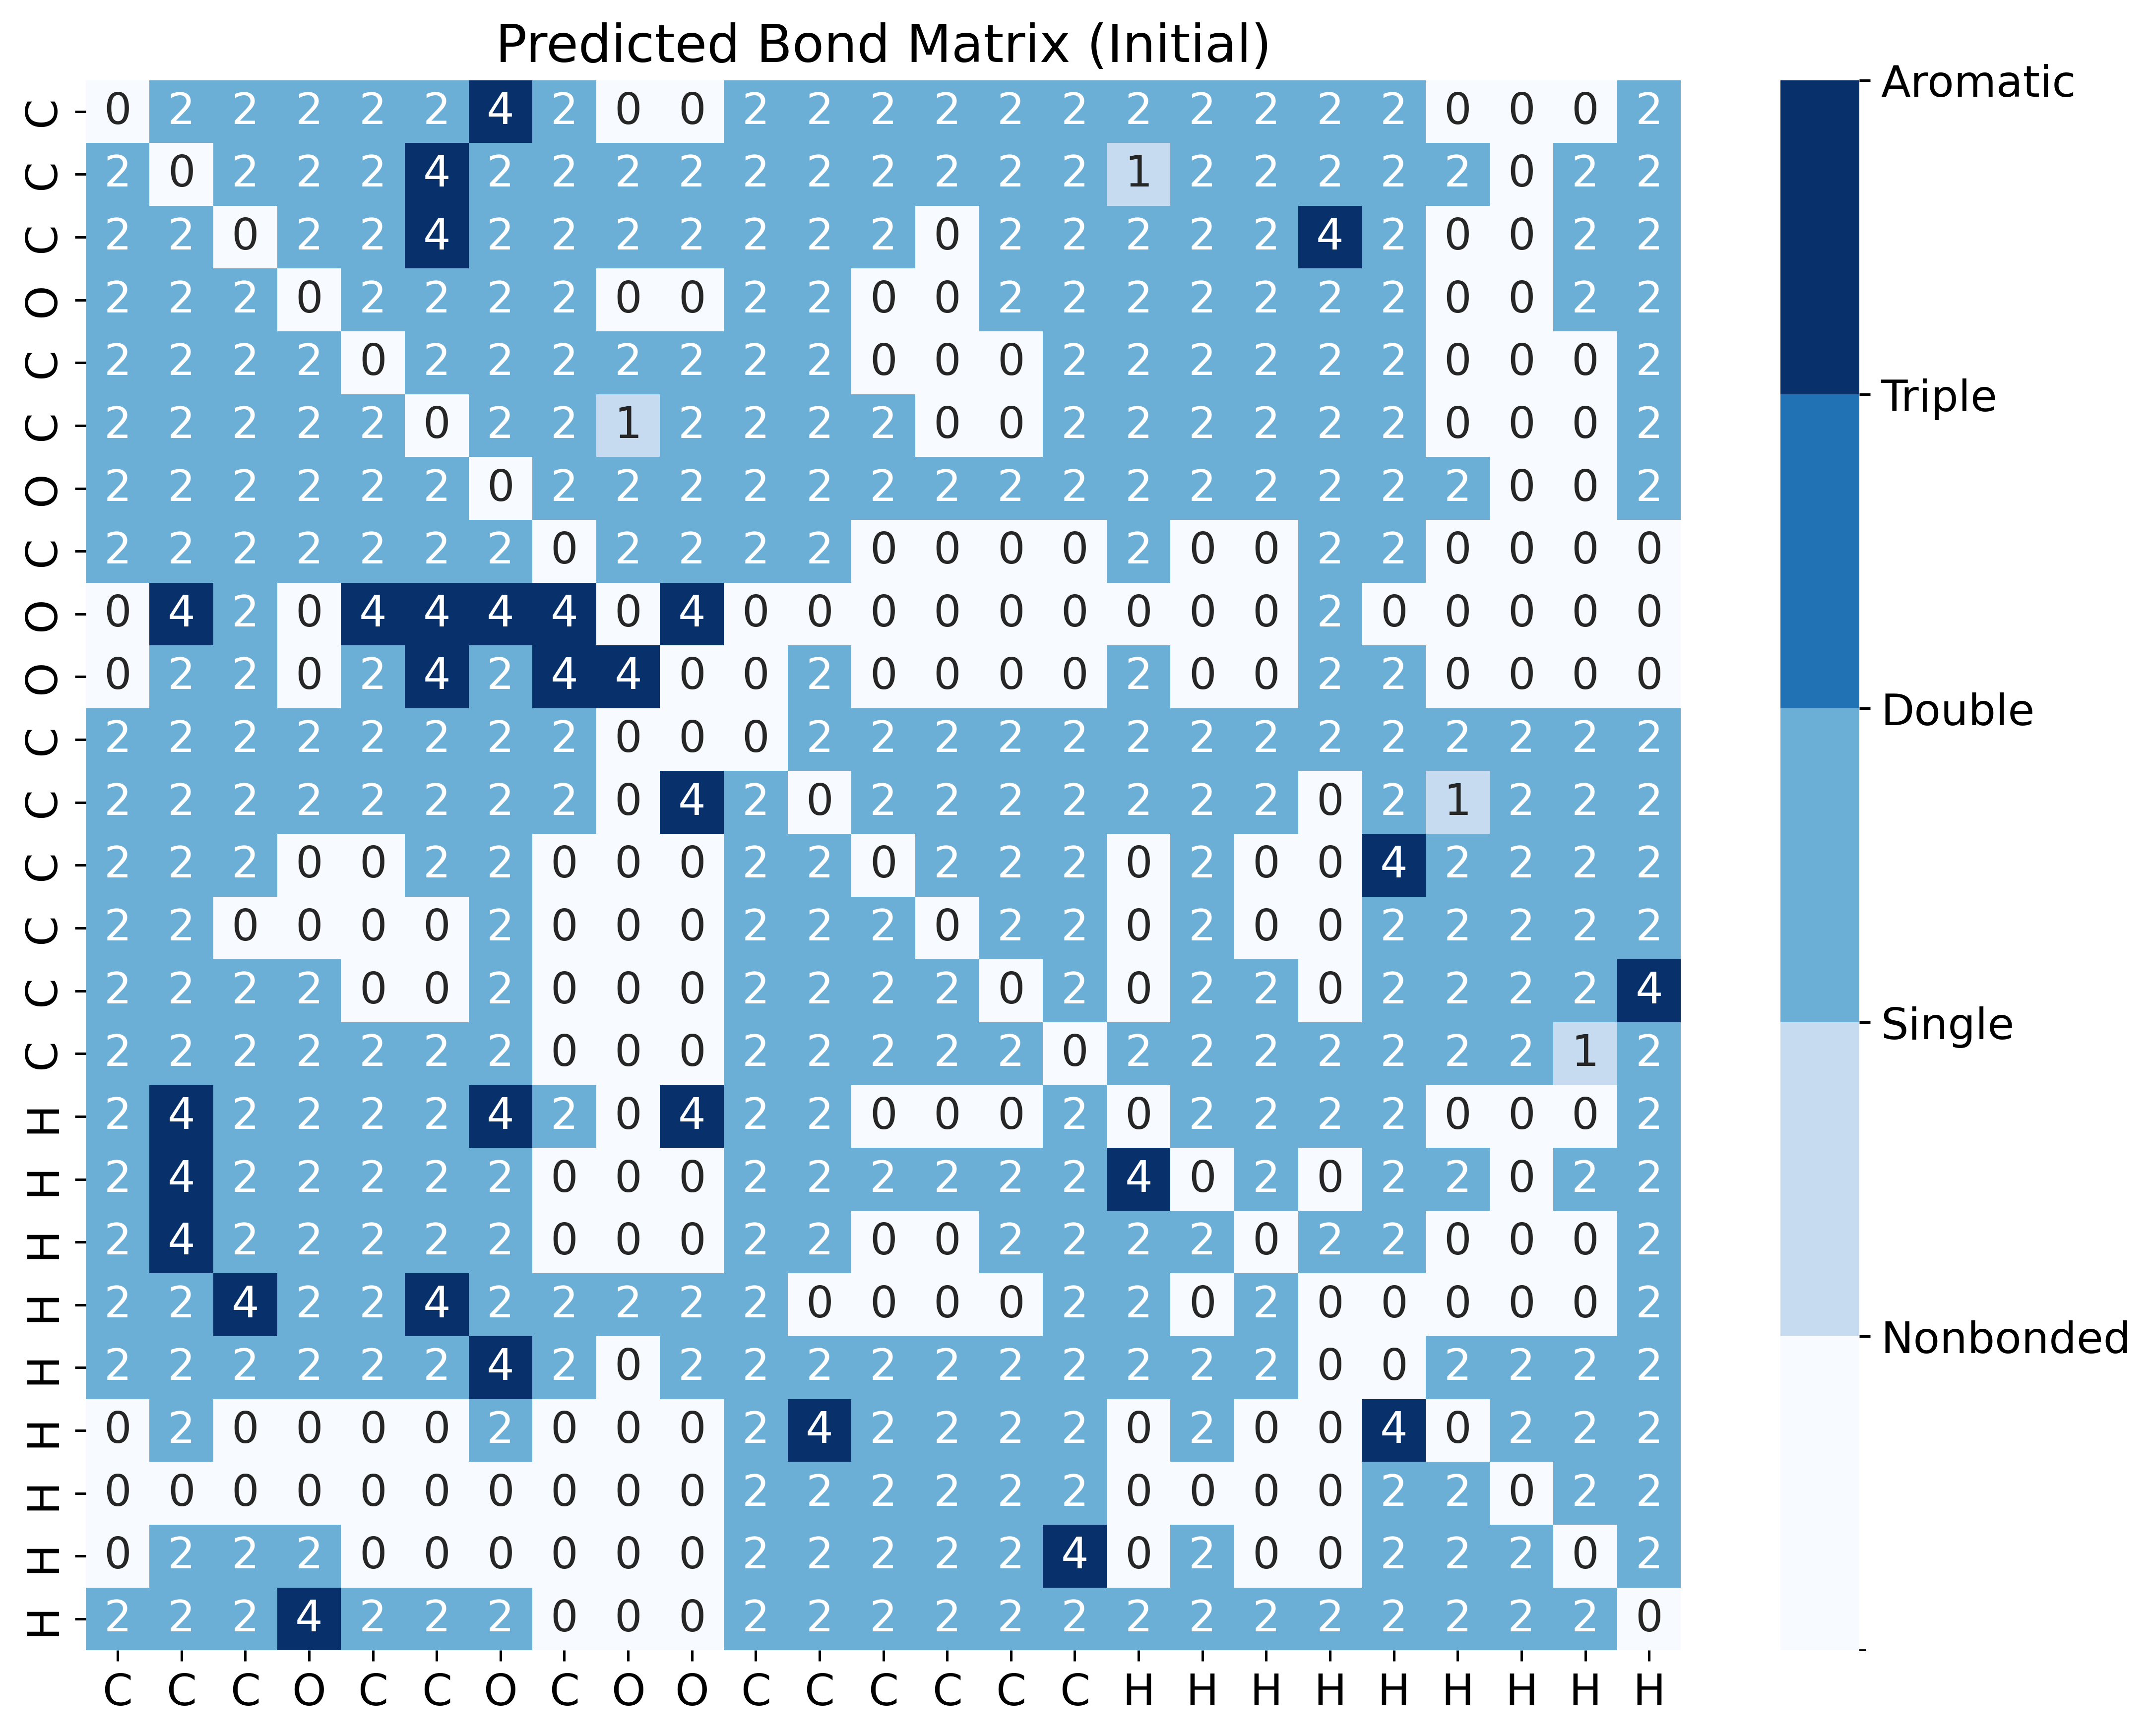

Molecule has 35 atoms
Coordinates shape: torch.Size([35, 3])
Atom types: tensor([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 16,  8,  6,  6,  8,
         7,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       device='cuda:0')
Bond matrix shape: torch.Size([35, 35])
Charges: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


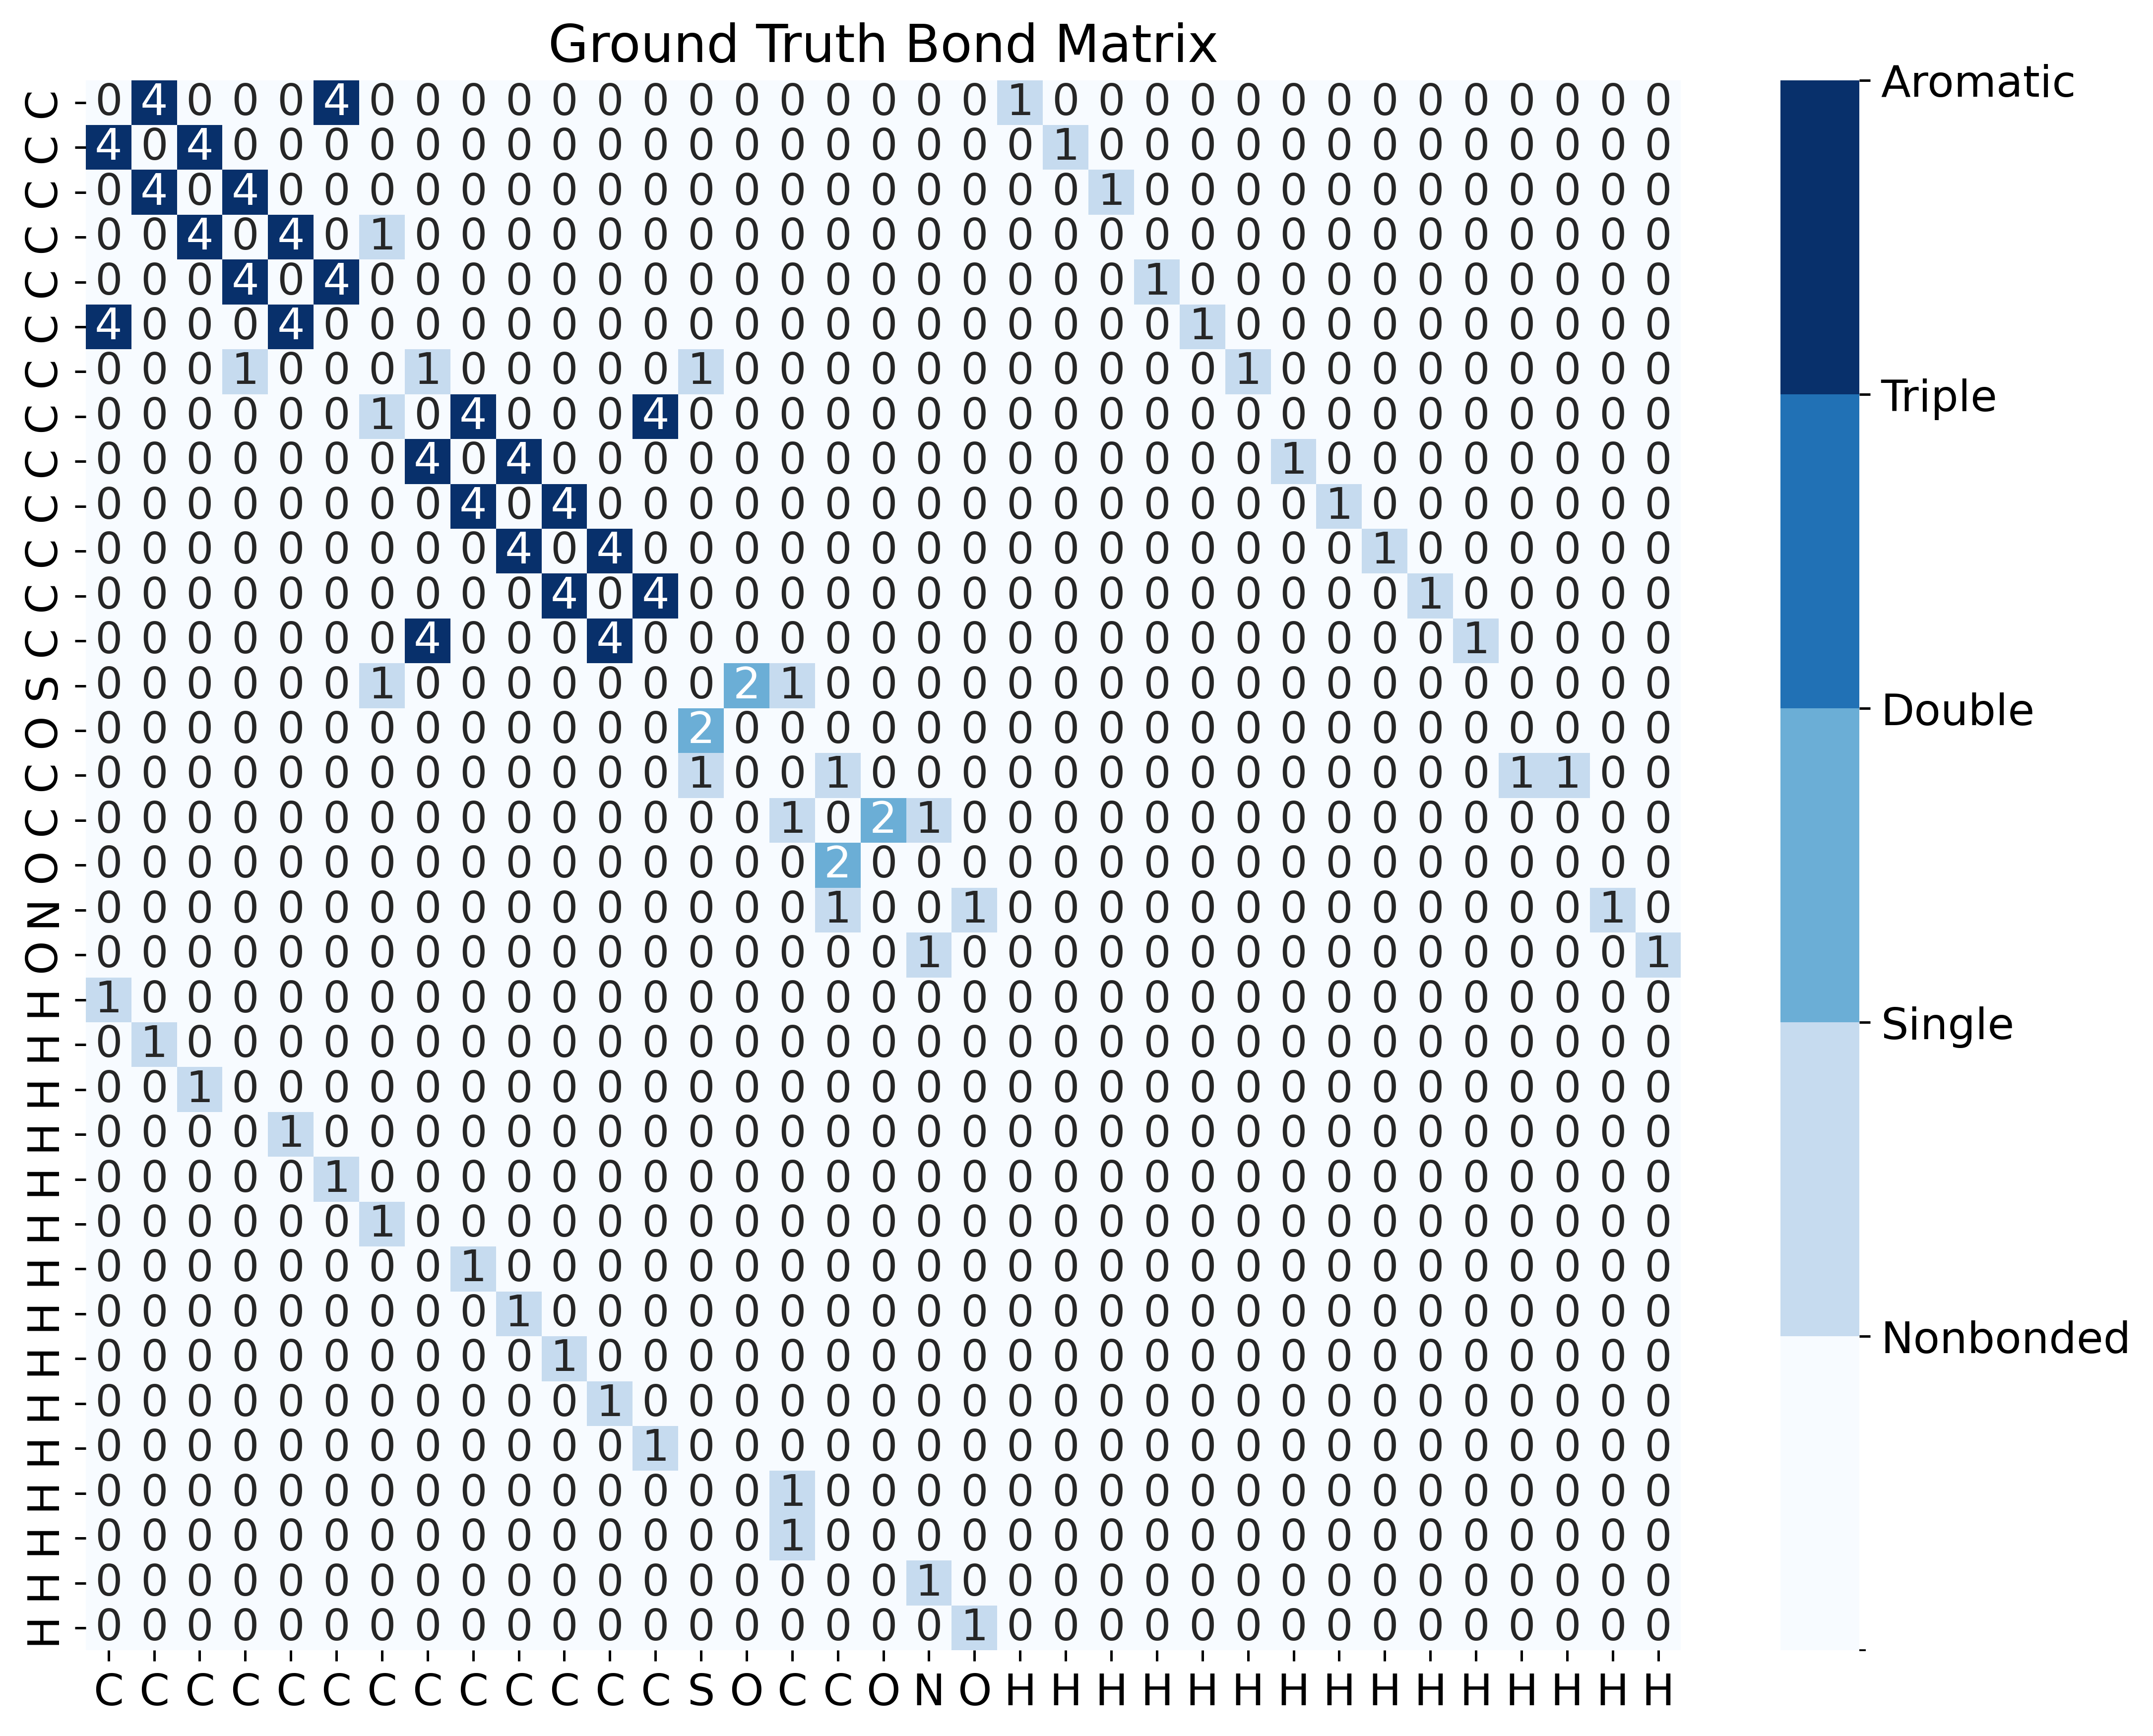

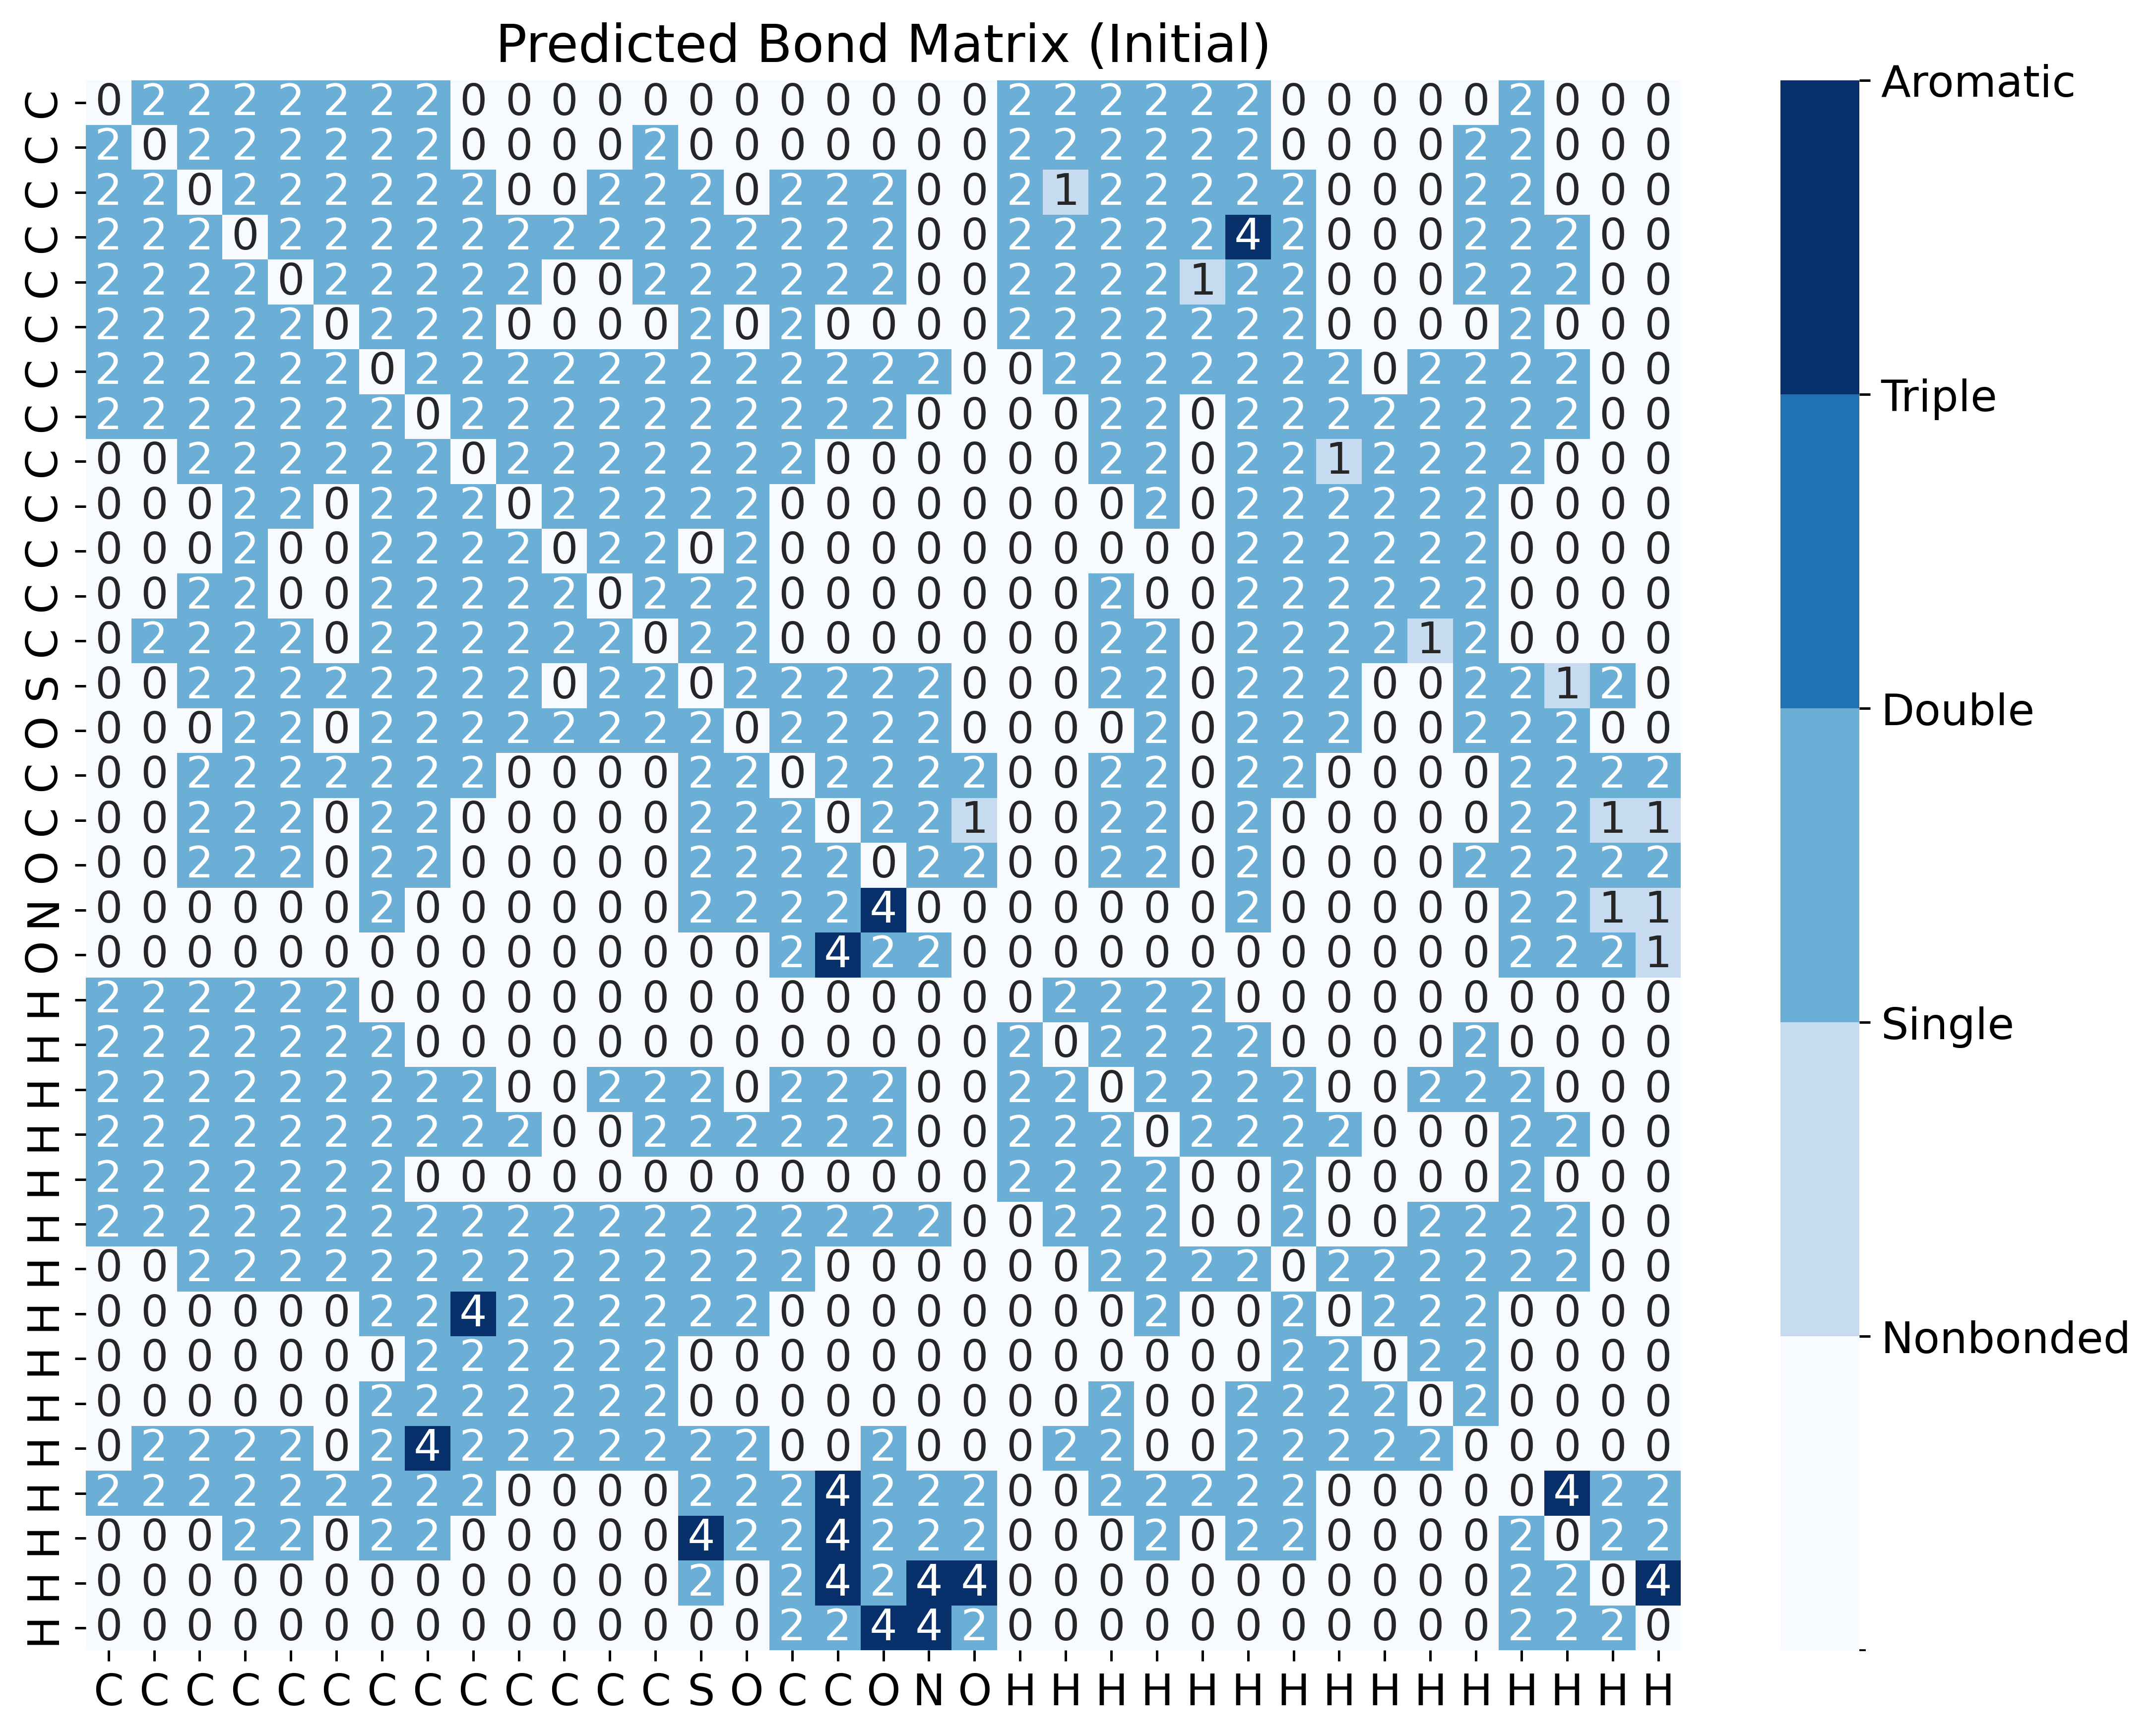

In [12]:
for mol in train_mols[:2]:
    # Get bond matrix and features
    coordinates, atom_types, bond_matrix, charges = rdkit_utils.embed_molecule_for_torch(mol)

    print(f"Molecule has {len(atom_types)} atoms")
    print(f"Coordinates shape: {coordinates.shape}")
    print(f"Atom types: {atom_types}")
    print(f"Bond matrix shape: {bond_matrix.shape}")
    print(f"Charges: {charges}")

    # Display bond matrix
    fig = visualize_bond_matrix(bond_matrix, atom_types)
    plt.title('Ground Truth Bond Matrix')
    plt.show()

    # Display predicted bond matrix
    bond_matrix_pred = predict_bond_matrix(coordinates, atom_types)
    fig = visualize_bond_matrix(bond_matrix_pred, atom_types)
    plt.title('Predicted Bond Matrix (Initial)')
    plt.show()

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

val_accuracies = []
val_accuracies_bonded = []
val_charge_accuracies = []

train_accuracies = []
train_accuracies_bonded = []
train_charge_accuracies = []

batch_size = 1
num_edges_for_loss = 96
bonded_edge_fraction = 0.25

with tqdm.tqdm(range(1000000)) as pbar:
    for step in pbar:
        optimizer.zero_grad()

        index = torch.randint(0, len(train_mols), (1,))
        mol = train_mols[index]
        try:
            coordinates, atom_types, bond_matrix, charges = rdkit_utils.embed_molecule_for_torch(mol)
        except ValueError:
            continue

        edge_index = e3tools.radius_graph(coordinates, r=net.radial_cutoff)
        bond_targets = bond_matrix[edge_index[0], edge_index[1]]
        charge_targets = embed_charges(charges, net.max_charge)

        # Choose a mix of bonded and non-bonded edges for the loss.
        # bonded_indices = torch.nonzero(bond_targets != 0).squeeze()
        # bonded_indices_subsample = torch.randint(0, len(bonded_indices), (int(num_edges_for_loss * bonded_edge_fraction),))
        # bonded_indices = bonded_indices[bonded_indices_subsample]

        # non_bonded_indices = torch.nonzero(bond_targets == 0).squeeze()
        # non_bonded_indices_subsample = torch.randint(0, len(non_bonded_indices), (num_edges_for_loss - len(bonded_indices),))
        # non_bonded_indices = non_bonded_indices[non_bonded_indices_subsample]
        # edge_indices_for_loss = torch.cat([bonded_indices, non_bonded_indices])

        bond_logits, charge_logits = predict_logits(coordinates, atom_types, edge_index)
        loss = criterion(bond_logits, bond_targets) + criterion(charge_logits, charge_targets)
        
        loss.backward()
        optimizer.step()

        if step % 10000 == 0:
            torch.save(net.state_dict(), f'weights_step_{step}.pt')

        if step % 10 == 0:
            bond_targets_pred = to_predictions(bond_logits)
            accuracy = (bond_targets_pred == bond_targets).float().mean()
            accuracy_bonded = (bond_targets_pred[bond_targets != 0] == bond_targets[bond_targets != 0]).float().mean()
            charge_pred = torch.argmax(charge_logits, dim=-1)
            charge_accuracy = (charge_pred == charge_targets).float().mean()
    
            index = torch.randint(0, len(validation_mols), (1,))
            val_mol = validation_mols[index]
            coordinates, atom_types, bond_matrix, charges = rdkit_utils.embed_molecule_for_torch(val_mol)
            bond_matrix_pred = predict_bond_matrix(coordinates, atom_types)

            val_accuracy = (bond_matrix_pred == bond_matrix).float().mean()
            val_accuracy_bonded = (bond_matrix_pred[bond_matrix != 0] == bond_matrix[bond_matrix != 0]).float().mean()

            val_charges = embed_charges(charges, net.max_charge)
            _, val_charge_logits = predict_logits(coordinates, atom_types)
            val_charge_pred = torch.argmax(val_charge_logits, dim=-1)
            val_charge_accuracy = (torch.argmax(val_charge_logits, dim=-1) == val_charges).float().mean()

            pbar.set_description(f"Loss: {loss.item():.4f}, Accuracy Bonded: {accuracy_bonded.item():.2f}, Val Accuracy Bonded: {val_accuracy_bonded.item():.2f}, Charge Accuracy: {charge_accuracy.item():.2f}, Val Charge Accuracy: {val_charge_accuracy.item():.2f}")

            val_accuracies.append(val_accuracy.item())
            val_accuracies_bonded.append(val_accuracy_bonded.item())
            val_charge_accuracies.append(val_charge_accuracy.item())
            
            train_accuracies.append(accuracy.item())
            train_accuracies_bonded.append(accuracy_bonded.item())
            train_charge_accuracies.append(charge_accuracy.item())


  0%|          | 0/1000000 [00:00<?, ?it/s]

Loss: 0.0038, Accuracy Bonded: 1.00, Val Accuracy Bonded: 1.00, Charge Accuracy: 1.00, Val Charge Accuracy: 1.00:   7%|▋         | 65428/1000000 [1:09:14<10:28:54, 24.77it/s] [19:32:42] UFFTYPER: Unrecognized charge state for atom: 13
Loss: 0.0025, Accuracy Bonded: 1.00, Val Accuracy Bonded: 1.00, Charge Accuracy: 1.00, Val Charge Accuracy: 1.00:   8%|▊         | 84920/1000000 [1:32:13<10:43:03, 23.72it/s] 

In [ ]:
# Save weights.
torch.save(net.state_dict(), 'weights.pth')

In [ ]:
plt.plot(val_accuracies_bonded, label='Validation', lw=1, ms=1)
plt.plot(train_accuracies_bonded, label='Train', lw=1, ms=1)
plt.legend(loc="center right", bbox_to_anchor=(1.5, 0.5))
plt.ticklabel_format(style='plain')
plt.xlabel('Step')
plt.ylabel('Accuracy over Bonded Atoms')
plt.title('Accuracy over Bonded Atoms')
plt.show()

plt.plot(val_charge_accuracies, label='Validation', lw=1, ms=1)
plt.plot(train_charge_accuracies, label='Train', lw=1, ms=1)
plt.legend(loc="center right", bbox_to_anchor=(1.5, 0.5))
plt.ticklabel_format(style='plain')
plt.xlabel('Step')
plt.ylabel('Accuracy of Charges')
plt.title('Accuracy of Charges')
plt.show()

In [ ]:
mol = validation_mols[0]
coordinates, atom_types, bond_matrix, charges = rdkit_utils.embed_molecule_for_torch(mol)
bond_matrix_pred = predict_bond_matrix(coordinates, atom_types)

R = e3nn.o3.rand_matrix()
coordinates_rot = coordinates @ R.T
bond_matrix_pred_rot = predict_bond_matrix(coordinates_rot, atom_types)

print(f"Accuracy: {(bond_matrix_pred == bond_matrix).float().mean().item():.4f}")
print(f"Accuracy Bonded: {(bond_matrix_pred[bond_matrix != 0] == bond_matrix[bond_matrix != 0]).float().mean().item():.4f}")

print(f"Accuracy (Rotated): {(bond_matrix_pred_rot == bond_matrix).float().mean().item():.4f}")
print(f"Accuracy Bonded (Rotated): {(bond_matrix_pred_rot[bond_matrix != 0] == bond_matrix[bond_matrix != 0]).float().mean().item():.4f}")

visualize_bond_matrix(bond_matrix, atom_types)
plt.title('Ground Truth')
plt.show()

visualize_bond_matrix(bond_matrix_pred, atom_types)
plt.title('Predicted')
plt.show()

visualize_bond_matrix(bond_matrix_pred_rot, atom_types)
plt.title('Predicted (Rotated)')
plt.show()

In [ ]:
# Try a different molecule
# ("Aspirin", "CC(=O)OC1=CC=CC=C1C(=O)O"),
# ("Caffeine", "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"),
# ("Benzene", "C1=CC=CC=C1")

mol = Chem.MolFromSmiles("CC(=O)OC1=CC=CC=C1C(=O)O")
mol = Chem.AddHs(mol, addCoords=True)

coordinates, atom_types, bond_matrix, charges = rdkit_utils.embed_molecule_for_torch(mol)
bond_matrix_pred = predict_bond_matrix(coordinates, atom_types)

print(f"Accuracy: {(bond_matrix_pred == bond_matrix).float().mean().item():.4f}")
print(f"Accuracy Bonded: {(bond_matrix_pred[bond_matrix != 0] == bond_matrix[bond_matrix != 0]).float().mean().item():.4f}")

visualize_bond_matrix(bond_matrix, atom_types)
plt.title('Ground Truth')
plt.show()

visualize_bond_matrix(bond_matrix_pred, atom_types)
plt.title('Predicted')
plt.show()

